In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# %% load data
data_dir = r'C:\Users\Timothy Lim\Desktop\junyi\archive'
content_data = pd.read_csv(os.path.join(data_dir, 'Info_Content.csv'))
user_data = pd.read_csv(os.path.join(data_dir, 'Info_UserData.csv'))
log_data = pd.read_csv(os.path.join(data_dir, 'Log_Problem.csv'))

print(content_data.shape)
print(user_data.shape)
print(log_data.shape)

(1330, 10)
(72758, 12)
(16217311, 14)


### log data

In [11]:
# does the number of times a student encountered a problem affect the prob of it being answered correctly? 
correct_mask = log_data['is_correct']==True
log_data[correct_mask]['total_attempt_cnt'].value_counts()

1    11412555
2           3
Name: total_attempt_cnt, dtype: int64

Exercise is the most basic unit of learning. Each exercise consists of several problems.

is_correct only tells us if the question is answered correctly the first time. need to find some other way to figure out how many attempts it takes for students to get an answer correct.

In [12]:
# does the number of times a problem is repeated in an exercise affect if its correct?
log_data[correct_mask]['exercise_problem_repeat_session'].value_counts()

1      9849149
2      1077891
3       265372
4        99109
5        45374
        ...   
108          3
106          3
105          3
104          3
119          3
Name: exercise_problem_repeat_session, Length: 119, dtype: int64

**exercise_problem_repeat_session** represents the number of times a problem is encountered in a given exercise session. it seems more meaningful than **total_attempt_cnt** for determining if a student correctly answers a question. 

maybe **total_attempt_cnt** can be used as a measure of how 'hardworking' students are in learning from their mistakes. 

In [20]:
# convenience functions

def compare_col(what):
    '''
    helper function to compare distribution of column for correct/wrong answers
    '''
    correct_mask = log_data['is_correct']==True
    correct_ans = log_data[correct_mask][what]
    wrong_ans = log_data[~correct_mask][what]
    
    # plot histogram
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    correct_ans.plot(kind='hist', alpha=0.5)
    wrong_ans.plot(kind='hist', color='orange', alpha=0.5)
    ax.legend(['is_correct', 'not is_correct'])
    plt.title(f'correct/wrong answers based on {what}')
    plt.show()
    

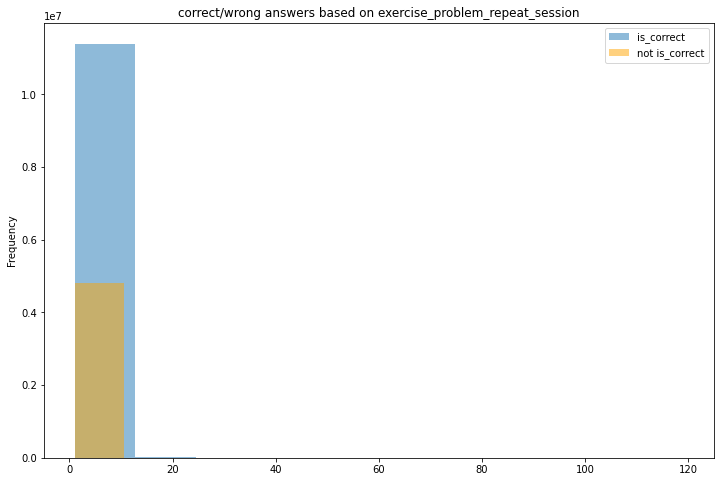

In [14]:
what = 'exercise_problem_repeat_session'
compare_col(what)

ok, it matches our intuition that students will likely get answers correct after encountering the same problem multiple times.

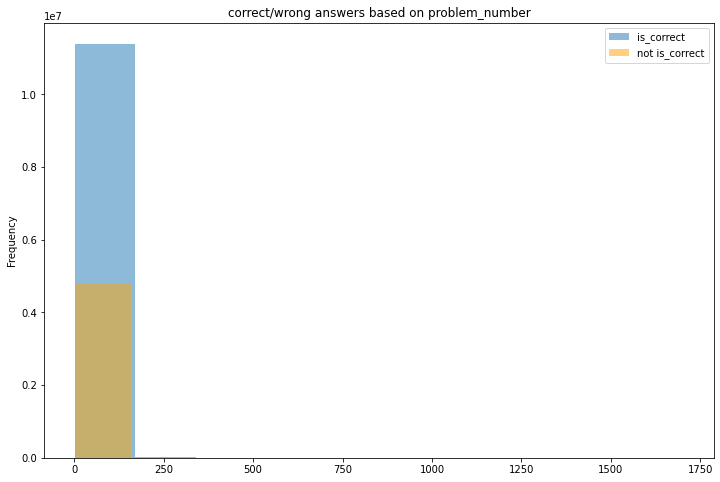

In [15]:
# does the problem_number affect whether students will get an answer correct? 

what = 'problem_number'
compare_col(what)

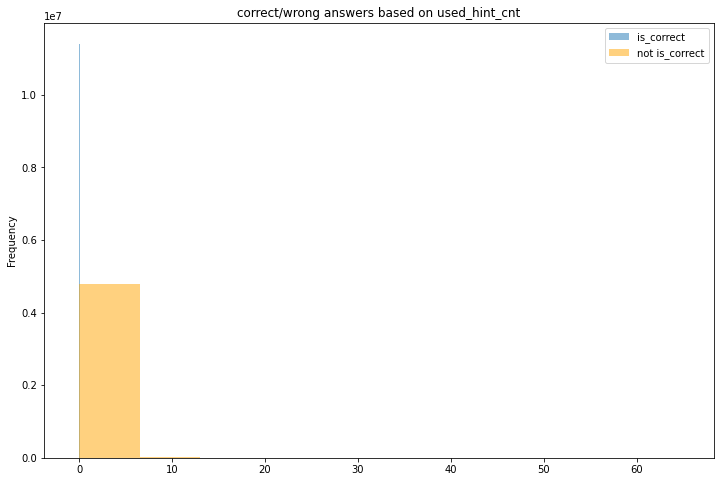

In [16]:
# does hints affect the students performance? 
what = 'used_hint_cnt'
compare_col(what)

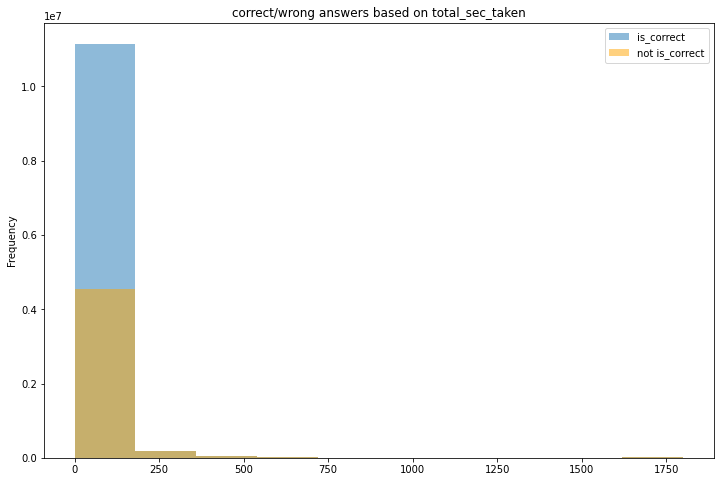

In [17]:
# does time taken affect the students performance? 
what = 'total_sec_taken'
compare_col(what)

In [18]:
log_data[correct_mask]['used_hint_cnt'].value_counts()

0    11412558
Name: used_hint_cnt, dtype: int64

In [43]:
log_data[correct_mask]['is_hint_used'].value_counts()

False    11412558
Name: is_hint_used, dtype: int64

it seems that hints may not help the students in getting a correct answer, or maybe hints are only showed if they got the question wrong the first time. 

students who spend a longer time on the problem will probably get it wrong 

**is_downgrade, is_upgrade**, and **level** columns after the student has answered the question. we need to shift these down by 1, so that it is the input for the next recorded instance. 

In [4]:
import datetime as dt
log_data['timestamp_TW'] = log_data['timestamp_TW'].apply(lambda x: dt.datetime.strptime(x.split(" ")[0], "%Y-%m-%d"))
log_data['timestamp_TW']

0          2019-05-26
1          2019-05-17
2          2019-05-15
3          2019-05-05
4          2019-05-14
              ...    
16217306   2019-04-28
16217307   2019-04-25
16217308   2019-04-25
16217309   2019-04-12
16217310   2019-04-01
Name: timestamp_TW, Length: 16217311, dtype: datetime64[ns]

In [5]:
 # sort columns
log_data.sort_values(by='timestamp_TW', ascending=True, inplace=True)

In [6]:
log_data['timestamp_TW']

13294313   2018-08-01
11613710   2018-08-01
3616950    2018-08-01
3616913    2018-08-01
11613766   2018-08-01
              ...    
13403866   2019-08-01
9972993    2019-08-01
226297     2019-08-01
1990316    2019-08-01
1737842    2019-08-01
Name: timestamp_TW, Length: 16217311, dtype: datetime64[ns]

In [7]:
def shift_cols(cols_to_shift, grouper=None):
    '''
    cols_to_shift: list of column names as strings
    grouper: key to identify the columns by
    '''
    if grouper:
        tmp = log_data.groupby(by=grouper)
    else:
        tmp = log_data 
    
    for col_to_shift in cols_to_shift:
        shifted_col = tmp[col_to_shift].shift(1)
        log_data[f'{col_to_shift}_shifted'] = shifted_col

# test case
shift_cols(['level'], 'uuid')
log_data[log_data['uuid']==log_data['uuid'][0]][['level', 'level_shifted']]

,level,level_shifted
1300997,1,NaN
15693133,0,1.0
2777300,0,0.0
771724,0,0.0
9281271,0,0.0
...,...,...
5087693,0,1.0
11246356,1,0.0
9932367,1,1.0
6385238,0,1.0


In [8]:
# shift cols down
shift_cols(['is_downgrade', 'is_upgrade', 'level'], grouper='uuid')

log_data[['uuid', 'is_upgrade', 'is_upgrade_shifted']]

,uuid,is_upgrade,is_upgrade_shifted
13294313,cEu2Dd7HE/Y7qWNs9DzHEN/PaqsFlH8phSmF82H/L/s=,True,NaN
11613710,gfBNcroUy3jmHzvln83n/244nI2j+DgyC6ek/QBlpGk=,NaN,NaN
3616950,1XgQB7q0IuEpt0kW99Xbp/oPx3IbPGVCM7FfuyusyQA=,NaN,NaN
3616913,MSDDAH9U3u1TmuLXlK/gQJDaYz/kM75BizFpuyOk6bA=,NaN,NaN
11613766,j/Prqubd0XhHmteIdpCvOcq7IgV4Ib9qLXF1gwNI5ww=,NaN,NaN
...,...,...,...
13403866,hCyJTrhgUprNNWpJYKPcyHIxDHnbW91tv0OEM0wXSuI=,True,NaN
9972993,t2N6muKWIarXYsUVv/M4rOx/+Qe0Gy9eC0ufuf7vZ0c=,True,True
226297,t2N6muKWIarXYsUVv/M4rOx/+Qe0Gy9eC0ufuf7vZ0c=,NaN,True
1990316,sGOJQqhUQZ019GmVifddm/O5dw3EMODoBt6vJ4nhbiM=,NaN,NaN


In [9]:
# test case
log_data[log_data['uuid']=='FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q='][['level', 'level_shifted']]

,level,level_shifted
1300997,1,NaN
15693133,0,1.0
2777300,0,0.0
771724,0,0.0
9281271,0,0.0
...,...,...
5087693,0,1.0
11246356,1,0.0
9932367,1,1.0
6385238,0,1.0


Seems like it works..na values are cos the rows are shifted down by 1

In [11]:
def get_problem_sequence(student_id, exercise_id):
    '''
    returns the sequence of problems that the student encountered
    '''
    mask = (log_data['uuid']==student_id) & (log_data['ucid']==exercise_id)
    log_filtered = log_data[mask]
    
    # sort by problem number
    log_filtered.sort_values(by='problem_number', ascending=True, inplace=True)
    
    return log_filtered['upid']

# test case
test_student = log_data['uuid'][100]
test_exercise = log_data['ucid'][100]

get_problem_sequence(test_student, test_exercise)

C:\Users\Timothy Lim\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


16105881    kXytcKWbhDaoNLK4MNmC2PtFx4+NDNWupTvE/qr7P3s=
3181643     oeyNNjsvr2woNM3Yp8IGtai6VIhlVuwmflKGXzaDxj8=
12728200    UFPE4Q+9PnmsOldsHsoAUYkW30XDzBhBQmDgoWp+Txo=
9423058     sohrk9Azp2qw5VOcg5kCGaEUzK360c/WV4nc1o4gaWw=
100         x02UAohfJjSpEPeUmG9nmRb1QLREaSm3ctZtytYgJGo=
14290231    Ym0WyuqGg4bfvw8J0Pcpqai+5b3GX+HK4YEYgWwcE6w=
12815885    W1LtFqyc7h590fkBXDP/6r67NTRhXgBB9+UetGVRDDA=
4858245     G+OmTrlhAsjv06cBBYchh8nYXLXDXy2gi0E1LqzesrI=
3239054     t76kGbpxKeD7FnNYEverE5esqAyJT2tvDal1PG3XZso=
11344494    Qdd4K5KNzU+EJ+5+RX0c4hRzASR3DAkJz1bsHM7kh5w=
11290392    r44s4QzhyW/AG0CugpFqzXaq9VdpcoevuvavP49Se9I=
6409422     nFV2dlUnHK3CM8V5ad60uzCGOqA5l7j99JYS/nUMuKQ=
Name: upid, dtype: object

In [12]:
mask = (log_data['uuid']==test_student) & (log_data['ucid']==test_exercise)
log_filtered = log_data[mask]
 
log_filtered

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level,level_shifted,is_downgrade_shifted,is_upgrade_shifted
12728200,2019-05-30,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,UFPE4Q+9PnmsOldsHsoAUYkW30XDzBhBQmDgoWp+Txo=,3,1,True,66,1,0,False,NaN,NaN,0,0.0,NaN,NaN
3181643,2019-05-30,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,oeyNNjsvr2woNM3Yp8IGtai6VIhlVuwmflKGXzaDxj8=,2,1,False,187,2,0,False,NaN,NaN,0,0.0,NaN,NaN
100,2019-05-30,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,x02UAohfJjSpEPeUmG9nmRb1QLREaSm3ctZtytYgJGo=,5,1,True,56,1,0,False,NaN,NaN,0,0.0,NaN,NaN
9423058,2019-05-30,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,sohrk9Azp2qw5VOcg5kCGaEUzK360c/WV4nc1o4gaWw=,4,1,True,65,1,0,False,NaN,NaN,0,0.0,NaN,NaN
16105881,2019-05-30,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,kXytcKWbhDaoNLK4MNmC2PtFx4+NDNWupTvE/qr7P3s=,1,1,True,74,1,0,False,NaN,NaN,0,0.0,NaN,NaN
14290231,2019-05-31,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,Ym0WyuqGg4bfvw8J0Pcpqai+5b3GX+HK4YEYgWwcE6w=,6,1,True,39,1,0,False,NaN,NaN,0,0.0,NaN,NaN
11344494,2019-05-31,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,Qdd4K5KNzU+EJ+5+RX0c4hRzASR3DAkJz1bsHM7kh5w=,10,1,True,18,1,0,False,NaN,NaN,0,0.0,NaN,NaN
11290392,2019-05-31,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,r44s4QzhyW/AG0CugpFqzXaq9VdpcoevuvavP49Se9I=,11,1,True,34,1,0,False,NaN,NaN,0,0.0,NaN,NaN
6409422,2019-05-31,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,nFV2dlUnHK3CM8V5ad60uzCGOqA5l7j99JYS/nUMuKQ=,12,1,True,9,1,0,False,NaN,NaN,0,0.0,NaN,NaN
12815885,2019-05-31,+AboU+pVNZXv2ZK2l01twEtYk3BbXeazrebuX0b8KIU=,A2548sl8hqkIMIGY7mlg/p2NN83cncQx2SgT00lyByk=,W1LtFqyc7h590fkBXDP/6r67NTRhXgBB9+UetGVRDDA=,7,1,False,37,2,0,False,NaN,NaN,0,0.0,NaN,NaN


In [14]:
# how long is each exercise, on average?

max_problems = log_data.groupby(by='ucid')['problem_number'].max()

sum(max_problems) / len(max_problems)


118.39140271493213

In [45]:
log_data['level_shifted'].isna().sum()

72758

In [55]:
unique_levels[1] % 2

0.0

In [59]:
# how many log entries for students of each level?
log_data['level'].value_counts(normalize=True)

0    0.728180
1    0.145071
2    0.061466
3    0.046335
4    0.018948
Name: level, dtype: float64

nan
0.0
1.0
2.0
3.0
4.0


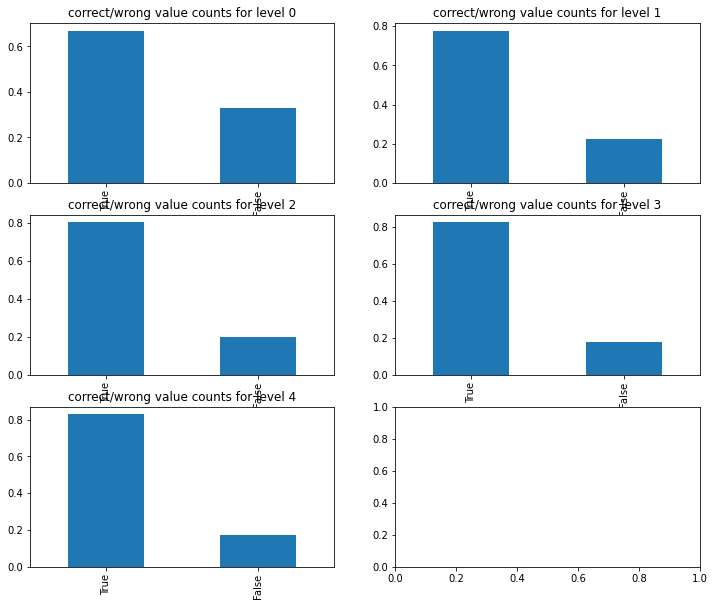

In [57]:
# does user performance improve with level?
unique_levels = log_data['level_shifted'].unique()

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for lvl in unique_levels:
    print(lvl)
    if np.isnan(lvl):
        continue
    lvl_mask = log_data['level_shifted']==lvl
    lvl_data = log_data[lvl_mask]
    lvl_data['is_correct'].value_counts(normalize=True).plot(kind='bar',
                                                             title=f"correct/wrong value counts for level {int(lvl)}",
                                                             ax=axes[int(lvl) // 2, int(lvl) % 2])
    

Lower level students do really get more questions wrong, but there is also considerably less data for these students 

In [60]:
def get_student_accuracy(student_id, exercise_id=None):
    '''
    helper function to return the % of questions answered correctly by student 
    if exercise_id is specified, only considers given exercise. 
    else will return agg accuracy across all exercises 
    '''
    student_mask = log_data['uuid']==student_id
    student_data = log_data[student_mask]
    
    if exercise_id:
        exercise_mask = student_data['ucid']==exercise_id
        student_data = student_data[exercise_mask]
    
    # accuracy = # questions answered correctly / # questions attempted
    student_accuracy = sum(student_data['is_correct']) / len(student_data['is_correct'])
    return student_accuracy

# test case
get_student_accuracy(log_data['uuid'][0])

0.8421052631578947

In [66]:
pivot_correct = log_data.pivot_table(values='is_correct', index='uuid', aggfunc='sum')
pivot_attempted = log_data.pivot_table(values='is_correct', index='uuid', aggfunc='count')

student_accuracies = pivot_correct / pivot_attempted
student_accuracies


,is_correct
uuid,
++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,1.000000
++9EkR6syMGk44XpyhOj40cg9xiXwCLS/TwEy+ujrL0=,0.103448
++E4TrlDYvGtPBg1edhkLXLEEbnfiAgAamPQ33vpW8M=,0.700000
++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,0.560976
++GobOSWqrsaxoRg1bMN+T6biIJcgBXwuOH/ddq3DiU=,0.883871
...,...
zztwLsjf44Uzumou84qh04wObpugkIllLCIp/mgoMu8=,0.884615
zzueVRV14tXIEgW4ixiqmtPNaFYz4MIifbMM/H2tmqA=,0.666667
zzujjvdKzb4wL8cFKdF3Of5gg2XHzIDQCZ2TfaYpSNs=,0.552743


<AxesSubplot:title={'center':'distribution of student accuracies'}, ylabel='Frequency'>

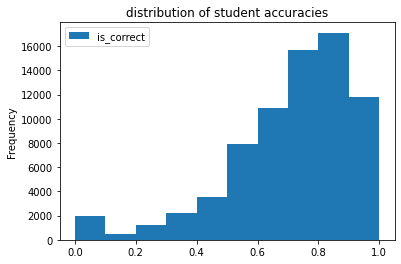

In [68]:
student_accuracies.plot(kind='hist', title='distribution of student accuracies')

<AxesSubplot:title={'center':'# of courses taken by students'}, ylabel='Frequency'>

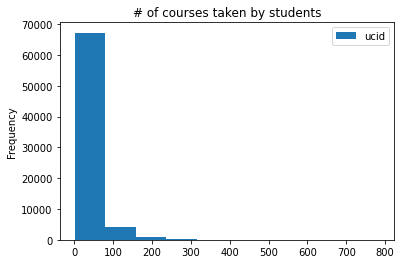

In [79]:
# number of exercises attempted by each student
pivot_courses = log_data.pivot_table(index='uuid', values='ucid', aggfunc=pd.Series.nunique)
pivot_courses.plot(kind='hist', title='# of courses taken by students')

<AxesSubplot:title={'center':'# of courses taken by students (without top 25%)'}, ylabel='Frequency'>

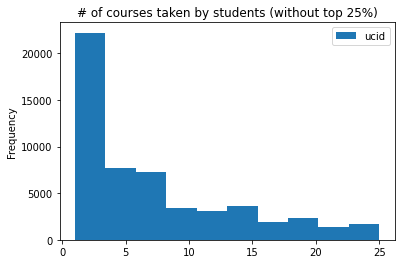

In [80]:
# number of exercises attempted by each student, if we remove the top 25% grinders... 
pivot_courses = log_data.pivot_table(index='uuid', values='ucid', aggfunc=pd.Series.nunique)
top_25 = pivot_courses.quantile(0.75)
pivot_courses[pivot_courses < top_25].plot(kind='hist', title='# of courses taken by students (without top 25%)')

<AxesSubplot:title={'center':'# of problems attempted by students'}, ylabel='Frequency'>

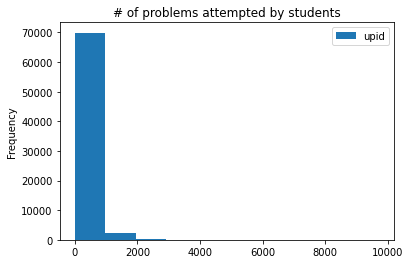

In [81]:
# number of unique problems attempted by each student
pivot_problems = log_data.pivot_table(index='uuid', values='upid', aggfunc=pd.Series.nunique)
pivot_problems.plot(kind='hist', title='# of problems attempted by students')

<AxesSubplot:title={'center':'# of problems attempted by students'}, ylabel='Frequency'>

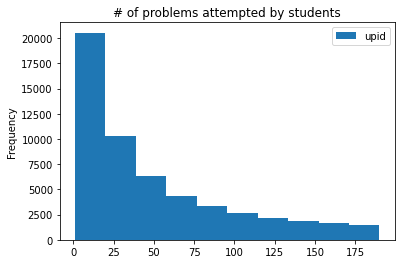

In [82]:
# number of unique problems attempted by each student, remove top 25% grinders
pivot_problems = log_data.pivot_table(index='uuid', values='upid', aggfunc=pd.Series.nunique)
top_25 = pivot_problems.quantile(0.75)
pivot_problems[pivot_problems < top_25].plot(kind='hist', title='# of problems attempted by students')

In [83]:
pivot_courses.quantile(0.75)

ucid    26.0
Name: 0.75, dtype: float64

In [84]:
pivot_problems.quantile(0.75)

upid    191.0
Name: 0.75, dtype: float64

### To do: 
EDA on student behavior metrics / interactions with learning platform. for eg, 

1. what is the average time spent between questions?  is there any relation between this and their level? or their accuracy? 
2. how many exercises do students attempt in a single day? how many problems do they attempt in a single day? a week? a month? 
